

### Name: Abdul Oladosu

## Overview

### Machine Learning Task

GOAL: Create a regression model to predict a student's grade.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler


from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR


from sklearn.metrics import mean_squared_error, r2_score


In [5]:

df = pd.read_csv('student-mat.csv')

In [4]:
df.shape
df.head(5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   school       395 non-null    object 
 1   sex          395 non-null    object 
 2   age          383 non-null    float64
 3   address      395 non-null    object 
 4   famsize      395 non-null    object 
 5   Pstatus      395 non-null    object 
 6   Medu         395 non-null    int64  
 7   Fedu         395 non-null    int64  
 8   Mjob         395 non-null    object 
 9   Fjob         395 non-null    object 
 10  reason       395 non-null    object 
 11  guardian     395 non-null    object 
 12  traveltime   395 non-null    int64  
 13  studytime    395 non-null    int64  
 14  failures     395 non-null    int64  
 15  schoolsup    395 non-null    object 
 16  famsup       395 non-null    object 
 17  paid         395 non-null    object 
 18  activities   395 non-null    object 
 19  nursery 

In [6]:
#This is to drop the target column from the rest of the data
target_col = 'G3'
X = df.drop(columns=[target_col])
y = df[target_col]

In [7]:
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

## Explore the Data
Understanding your data is a crucial step before building any machine learning model. This exploration phase helps identify patterns, detect anomalies, and uncover insights that will guide modeling decisions. By thoroughly analyzing and visualizing the data, you can make informed choices on feature selection and preprocessing, ultimately improving your model's performance and reliability.


In this section i would:
1) **Study Attributes**: Thoroughly study the training set attributes and their characteristics.
2) **Visualizations**: Use visualizations to effectively analyze and explore your data.  
3) **Correlations**: Analyze correlations between numeric attributes.

Will explain what the visualization shows and why it is important in the executive summary document.



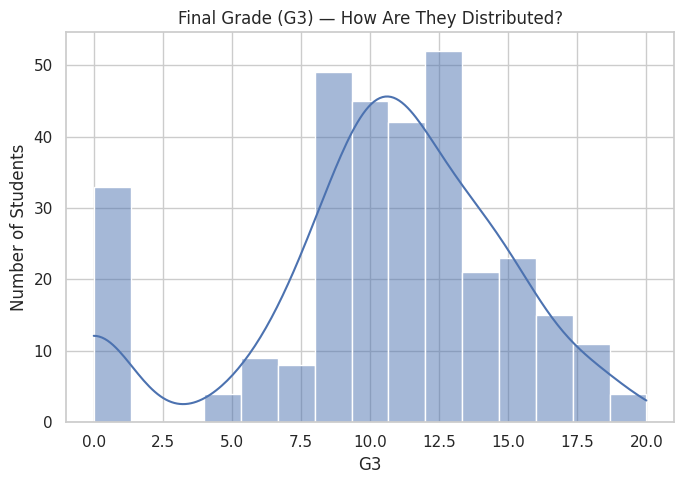

In [8]:


# Build a train-only frame so our plots reflect what the model actually "saw"
train_df = X_train.copy()
train_df['G3'] = y_train

# This keeps only columns that really exist in this dataset
def keep_existing(cols, frame):
    return [c for c in cols if c in frame.columns]

# What do final grades look like?
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
plt.figure(figsize=(7,5))
sns.histplot(train_df['G3'], bins=15, kde=True)
plt.title('Final Grade (G3) — How Are They Distributed?')
plt.xlabel('G3')
plt.ylabel('Number of Students')
plt.tight_layout()



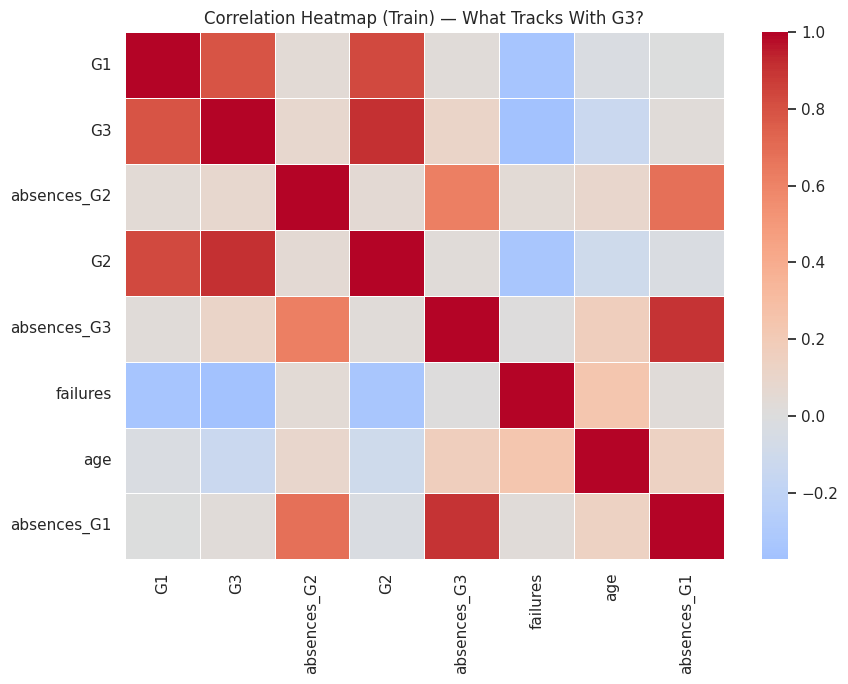

In [9]:
numeric_columns = [
    'absences_G1', 'absences_G2', 'absences_G3', 'G1', 'G2', 'failures', 'age']
#  Which numeric features move with G3?

num_cols_for_corr = keep_existing(list(set(numeric_columns + ['G3'])), train_df)
corr = train_df[num_cols_for_corr].corr(numeric_only=True)

plt.figure(figsize=(9,7))
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Heatmap (Train) — What Tracks With G3?')
plt.tight_layout()


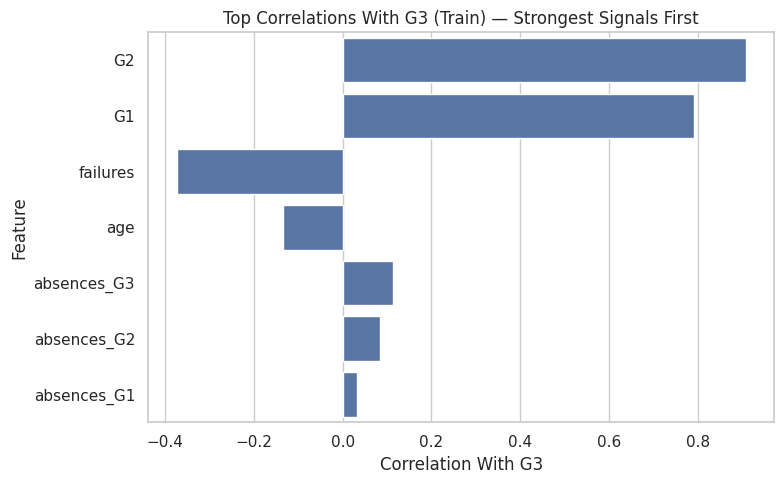

In [10]:
# 3) What are the top (absolute) correlations with G3?

if 'G3' in corr.columns:
    g3_corr = corr['G3'].drop(labels=['G3'], errors='ignore').sort_values(key=lambda s: s.abs(), ascending=False)
    top_n = g3_corr.head(10)  # show the top 10 strongest links to G3

    plt.figure(figsize=(8,5))
    sns.barplot(x=top_n.values, y=top_n.index, orient='h')
    plt.title('Top Correlations With G3 (Train) — Strongest Signals First')
    plt.xlabel('Correlation With G3')
    plt.ylabel('Feature')
    plt.tight_layout()


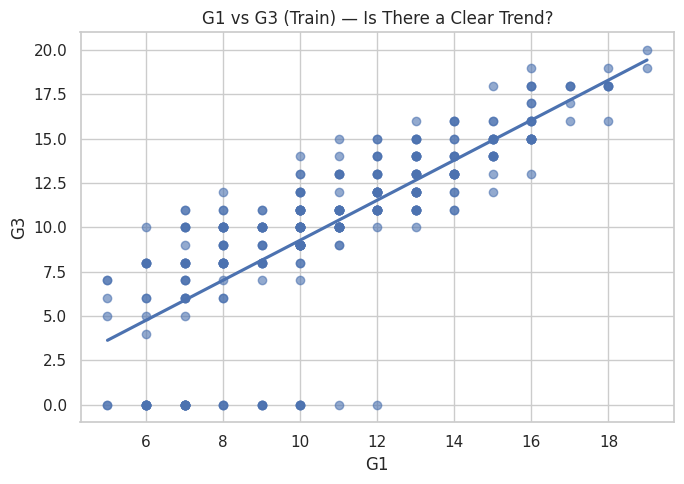

In [11]:
#4) How does an early-term grade relate to the final grade?

x_feat = 'G1' if 'G1' in train_df.columns else ('G2' if 'G2' in train_df.columns else None)
if x_feat is not None:
    plt.figure(figsize=(7,5))
    sns.regplot(data=train_df, x=x_feat, y='G3', scatter_kws={'alpha':0.6}, ci=None)
    plt.title(f'{x_feat} vs G3 (Train) — Is There a Clear Trend?')
    plt.xlabel(x_feat)
    plt.ylabel('G3')
    plt.tight_layout()

else:
    # If we don’t have G1/G2 in the raw train_df at this stage, try absences_sum if present.
    if 'absences_sum' in train_df.columns:
        plt.figure(figsize=(7,5))
        sns.regplot(data=train_df, x='absences_sum', y='G3', scatter_kws={'alpha':0.6}, ci=None)
        plt.title('Absences (Sum) vs G3 (Train) — More Absences, Lower Grades?')
        plt.xlabel('absences_sum')
        plt.ylabel('G3')
        plt.tight_layout()




## Preparing the Data

### Feature Selection

Based on our data exploration, we will consider the features we want to include in our model. Limiting our data can be beneficial because it reduces complexity and can improve model performance by focusing on the most relevant features.



In [13]:
#Selected numeric columns
numeric_columns = [
    'absences_G1', 'absences_G2', 'absences_G3', 'G1', 'G2', 'failures', 'age']

#Selected categorical columns
categorical_columns = ['sex', 'school', 'address', 'Mjob', 'Fjob']

#Selected ordinal columns
ordinal_columns = ['Medu', 'Fedu', 'studytime', 'traveltime']

### Custom Transformer
We want to create a new column that sums the three absences columns together as a new feature. Additionally, we want to  conditionally keep or drop the grades for the first and second terms based on the parameters passed.

G3 is the final year grade and is highly correlated with G2 and G1, which are grades from the first two terms. Predicting G3 without using G2 and G1 is more challenging but also more valuable since we could make predictions earlier in the year. Therefore, later we will create separate models (one that includes the G1 and G2 columns and one that excludes them) to test this.



In [14]:


class FinalProjectTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_grades: bool = False):
        self.drop_grades = drop_grades

    def fit(self, X, y=None):
        # No learned parameters; just return self
        return self

    def transform(self, X):
        # Expect a pandas DataFrame
        X_out = X.copy()

        # Create absences_sum and drop the originals
        required_abs_cols = ['absences_G1', 'absences_G2', 'absences_G3']
        missing_abs = [c for c in required_abs_cols if c not in X_out.columns]
        if missing_abs:
            raise ValueError(f"Missing required absence columns in input: {missing_abs}")

        X_out['absences_sum'] = (
            X_out['absences_G1'].astype(float) +
            X_out['absences_G2'].astype(float) +
            X_out['absences_G3'].astype(float)
        )
        X_out = X_out.drop(columns=required_abs_cols)

        # drop G1 and G2
        if self.drop_grades:
            for gcol in ['G1', 'G2']:
                if gcol in X_out.columns:
                    X_out = X_out.drop(columns=[gcol])

        return X_out

### Data Pipelines
Creating data pipelines allows us to automate your data cleaning process, making it easy to apply the same transformations to new data. We will create one with the G1/G2 columns and one without them.

Here are the steps we will take:

- Numeric Pipeline (We will create two to handle the G1/G2 requirement)
  - Impute missing values using SimpleImputer()
  - Transform data using the custom transformer FinalProjectTransformer as appropriate for the task
  - Standardize the data using StandardScalar()
  - Use the following variable names:
    - `numeric_pipeline_with_grades`
    - `numeric_pipeline_without_grades`

- Categorical Pipeline
  - Impute missing values
  - One-Hot Encode (OHE) categorical data
  - Use the following variable name:
    - `categorical_pipeline`

- Ordinal Pipeline
  - Impute missing values
  - Ordinal encode the data
  - Use the following variable name:
    - `ordinal_pipeline`

- Column Transformer (We will need to create two to handle the two different numeric pipelines)
  - pass in previously created feature selection lists
  - Combine the numeric, categorical, and ordinal pipelines
  - Use the following variable names:
    - `column_transformer_with_grades`
    - `column_transformer_without_grades`
    
Once the full pipeline is set up, fit and transform `X_train`, saving the results as `X_train_transformed_with_grades` and `X_train_transformed_without_grades`. Confirm that the transformed data without grades has two fewer columns.

In [15]:

# NUMERIC pipelines

numeric_pipeline_with_grades = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median').set_output(transform="pandas")),
    ('final_transform', FinalProjectTransformer(drop_grades=False)),
    ('scaler', StandardScaler())
])

numeric_pipeline_without_grades = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median').set_output(transform="pandas")),
    ('final_transform', FinalProjectTransformer(drop_grades=True)),
    ('scaler', StandardScaler())
])

# CATEGORICAL pipeline

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ORDINAL pipeline

ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # Unknown levels encoded as -1 so the model can still consume them
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# COLUMN TRANSFORMERS

column_transformer_with_grades = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline_with_grades, numeric_columns),
        ('cat', categorical_pipeline, categorical_columns),
        ('ord', ordinal_pipeline, ordinal_columns)
    ],
    remainder='drop'
)

column_transformer_without_grades = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline_without_grades, numeric_columns),
        ('cat', categorical_pipeline, categorical_columns),
        ('ord', ordinal_pipeline, ordinal_columns)
    ],
    remainder='drop'
)

# Fit/transform X_train into two training matrices
X_train_transformed_with_grades = column_transformer_with_grades.fit_transform(X_train)
X_train_transformed_without_grades = column_transformer_without_grades.fit_transform(X_train)

 #check: "without_grades" should have 2 fewer columns (G1, G2 removed in numeric pipe)
print("With grades shape:", X_train_transformed_with_grades.shape)
print("Without grades shape:", X_train_transformed_without_grades.shape)


With grades shape: (316, 25)
Without grades shape: (316, 23)


## Shortlist Promising Models
In this section, we will fit and compare three regression models to your transformed data, both with and without the G1/G2 columns, using cross-validation. Following the steps below.

1) **Initialize Three Regression Models**
- Linear Regression
- Support Vector Machine (SVM) Regression
- Lasso Regression

2) **Cross-Validation**: Using both sets of transformed data (with and without G1/G2 columns), perform 3-fold cross-validation for each model using RMSE as the metric.
  - cross-validation will be ran six times (e.g., cross-validation of the linear regression model with the G1/G2 data, cross-validation of the linear regression model without the G1/G2 data, etc.)
  

In [16]:

# Initialize three regressors
lin_reg = LinearRegression()
svm_reg = SVR()           # defaults (we'll tune later)
lasso_reg = Lasso(max_iter=10000)

# Helper for RMSE scoring in sklearn: use negative RMSE and flip sign
scoring = 'neg_root_mean_squared_error'
cv = 3

# With grades
cv_scores_lin_reg_with_grades = cross_val_score(lin_reg, X_train_transformed_with_grades, y_train,
                                                scoring=scoring, cv=cv)
cv_scores_svm_with_grades = cross_val_score(svm_reg, X_train_transformed_with_grades, y_train,
                                            scoring=scoring, cv=cv)
cv_scores_lasso_with_grades = cross_val_score(lasso_reg, X_train_transformed_with_grades, y_train,
                                              scoring=scoring, cv=cv)

# Without grades
cv_scores_lin_reg_without_grades = cross_val_score(lin_reg, X_train_transformed_without_grades, y_train,
                                                   scoring=scoring, cv=cv)
cv_scores_svm_without_grades = cross_val_score(svm_reg, X_train_transformed_without_grades, y_train,
                                               scoring=scoring, cv=cv)
cv_scores_lasso_without_grades = cross_val_score(lasso_reg, X_train_transformed_without_grades, y_train,
                                                 scoring=scoring, cv=cv)

# Means (flip sign to get positive RMSE)
rmse_lin_reg_with_grades = -cv_scores_lin_reg_with_grades.mean()
rmse_lin_reg_without_grades = -cv_scores_lin_reg_without_grades.mean()
rmse_svm_with_grades = -cv_scores_svm_with_grades.mean()
rmse_svm_without_grades = -cv_scores_svm_without_grades.mean()
rmse_lasso_with_grades = -cv_scores_lasso_with_grades.mean()
rmse_lasso_without_grades = -cv_scores_lasso_without_grades.mean()

print("CV mean RMSE (with grades):",
      "\n  Linear:", rmse_lin_reg_with_grades,
      "\n  SVM   :", rmse_svm_with_grades,
      "\n  Lasso :", rmse_lasso_with_grades)

print("CV mean RMSE (without grades):",
      "\n  Linear:", rmse_lin_reg_without_grades,
      "\n  SVM   :", rmse_svm_without_grades,
      "\n  Lasso :", rmse_lasso_without_grades)


CV mean RMSE (with grades): 
  Linear: 1.9076696936027222 
  SVM   : 2.4244179846134277 
  Lasso : 2.1690514380657917
CV mean RMSE (without grades): 
  Linear: 4.616550738634076 
  SVM   : 4.286068141858787 
  Lasso : 4.386455909382055


## Fine-Tune the System
We will use the Support Vector Machine (SVM) regression model and perform grid search to fine-tune its hyperparameters.

1) Set Up Grid Search for SVM Regression
  - Define a parameter grid to search over.
  - Use GridSearchCV to find the best hyperparameters.
  - Fit the grid search to both sets (with and without the G1/G2 columns) of the transformed training data.



In [17]:

# Define a reasonable param grid for SVR
param_grid = {
    'kernel': ['rbf', 'linear'],
    'C': [1.0, 10.0, 100.0],
    'epsilon': [0.1, 0.2, 0.5]
}

# WITH grades
grid_search = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1
)
grid_search.fit(X_train_transformed_with_grades, y_train)

best_params_with_grades = grid_search.best_params_
print("Best params (with grades):", best_params_with_grades)
print("Best CV score (neg RMSE, with grades):", grid_search.best_score_)

# WITHOUT grades (reusing the same variable name is fine)
grid_search = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1
)
grid_search.fit(X_train_transformed_without_grades, y_train)

best_params_without_grades = grid_search.best_params_
print("Best params (without grades):", best_params_without_grades)
print("Best CV score (neg RMSE, without grades):", grid_search.best_score_)


Best params (with grades): {'C': 1.0, 'epsilon': 0.5, 'kernel': 'linear'}
Best CV score (neg RMSE, with grades): -1.937714427520976
Best params (without grades): {'C': 1.0, 'epsilon': 0.5, 'kernel': 'rbf'}
Best CV score (neg RMSE, without grades): -4.272971263395108


## Measure Performance on Test Set
In this section, we will transform the test set using our full pipeline and measure the performance of our best model on the test set.
Following the steps below:

1) Based on all previous cross-validation results, pick our best model.
2) Use the previously created column transformers to transform the test set, both with and without the G1/G2 columns.
3) Using our best model, measure its performance on the test set to estimate the generalization error.


In [18]:



# 1) Transform the test set
X_test_transformed_with_grades = column_transformer_with_grades.transform(X_test)
X_test_transformed_without_grades = column_transformer_without_grades.transform(X_test)

# 2) Fit chosen best models
# WITH grades -Linear Regression
model_with = LinearRegression()
model_with.fit(X_train_transformed_with_grades, y_train)

# WITHOUT grades - plain SVR
model_without = SVR()
model_without.fit(X_train_transformed_without_grades, y_train)

# 3) Evaluate on the test set
# WITH grades
y_pred_with = model_with.predict(X_test_transformed_with_grades)
rmse_with_grades = np.sqrt(mean_squared_error(y_test, y_pred_with))
r2_with_grades = r2_score(y_test, y_pred_with)

# WITHOUT grades
y_pred_without = model_without.predict(X_test_transformed_without_grades)
rmse_without_grades = np.sqrt(mean_squared_error(y_test, y_pred_without))
r2_without_grades = r2_score(y_test, y_pred_without)

print("WITH grades  - LinearRegression | RMSE:", rmse_with_grades, " R²:", r2_with_grades)
print("WITHOUT      - SVR              | RMSE:", rmse_without_grades, " R²:", r2_without_grades)


WITH grades  - LinearRegression | RMSE: 2.224383428454071  R²: 0.758699330360151
WITHOUT      - SVR              | RMSE: 4.175460722100592  R²: 0.14974727861482418
